In [179]:
import sys
sys.path.append('../')

import controller
import torch
import torch.nn as nn
import random
import numpy as np
import matplotlib.pyplot as plt

In [183]:
CAR_MODEL = "complex"
ci = controller.Car_Interface(model = CAR_MODEL)

ci.set_gear(ci.FORWARD)

In [191]:
np.random.seed(191)

'''
We want to make a model that can tell you how much
you should depress the accelerator in order to achieve
a target speed after travelling a target distance.

Your goal is to randomly generate an (input, output)
pair that can be used for training or evaluating your
model. The input would be in the form of the final speed
achieved and the distance travelled and the output would
be the amount the pedal was accelerated to get there.
'''

def accelerate_until_velocity(ci, target_vel, amt):
    while(len(ci.log["velocity"]) == 0 or ci.log["velocity"][-1] < target_vel):
        ci.apply_control(pedal = ci.ACCELERATOR, amount = amt)


def accelerating_distance_gen(ci, t=50):
    target_vel = random.random()
    amt = 0.15 + random.random() * 0.85
    
    pos_initial = ci.log["position"][-1]
    
    ci.apply_control_for_time(pedal = ci.ACCELERATOR, amount = amt, time = t)
    
    final_speed = ci.log["velocity"][-1]
    
    distance_traveled = ci.log["position"][-1] - pos_initial 

    inp = [final_speed, distance_traveled]

    return amt, inp

In [192]:
amt, (final_speed, distance_travelled) = accelerating_distance_gen(ci)
print(f"A car applied {amt * 100:.2f}% accelerator, and achieved a speed of {final_speed * 100:.2f}% after travelling {distance_travelled:.2f} distance units")

A car applied 38.79% accelerator, and achieved a speed of 32.78% after travelling 19.01 distance units


In [193]:
'''
Function should return how much distance the car
would travel if the accelerator was being pressed amt
until it acheived final_velocity
'''
def actual_accelerating_distance(final_velocity, amt):
    #OPTIONAL CODE HERE
    return d

def approximate_amount(inp, tol = 1e-5, min_amt = 0, max_amt = 1):
    mid_amt = (min_amt + max_amt) / 2
    if (max_amt - min_amt < 2 * tol):
        return mid_amt

    v, accelerating_distance = inp
    if (actual_accelerating_distance(v, mid_amt) < accelerating_distance):
        return approximate_amount(inp, tol, min_amt, mid_amt)
    else:
        return approximate_amount(inp, tol, mid_amt, max_amt)

In [194]:
'''
Fully Connected Module used to predict
necessary accelerator pedal depression given
target velocity and target distance from standstill.
'''
class fcn(nn.Module):

    def __init__(self):
        super().__init__()

        self.H_1 = 30
        self.H_2 = 20

        self.W_1 = nn.Parameter(torch.randn([2, self.H_1]))
        self.B_1 = nn.Parameter(torch.randn([self.H_1]))

        self.W_2 = nn.Parameter(torch.randn([self.H_1, self.H_2]))
        self.B_2 = nn.Parameter(torch.randn([self.H_2]))

        self.W_3 = nn.Parameter(torch.randn([self.H_2, 1]))
        self.B_3 = nn.Parameter(torch.randn([1]))

    def forward(self, x):

        x = torch.tensor(x, dtype = torch.float32)

        h_1 = torch.tanh(torch.matmul(x, self.W_1) + self.B_1)

        h_2 = torch.tanh(torch.matmul(h_1, self.W_2) + self.B_2)

        out = torch.squeeze(torch.matmul(h_2, self.W_3) + self.B_3)

        return 1.15 * torch.sigmoid(out)

In [195]:
#Initialize training parameters here
NUM_BATCHES = 10
BATCH_SIZE = 30
EPOCHS = 10


#USE_LAST = True

FN = "weights_" + CAR_MODEL

model = fcn()
#if(USE_LAST):
#   model.load_state_dict(torch.load(open(FN + ".pt", "rb")))

#Initialize optimizer here
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

for e in range(EPOCHS):
    e_loss = 0
    for b in range(NUM_BATCHES):
        b_loss = 0
        for i in range(BATCH_SIZE):
            amt, inp = accelerating_distance_gen(ci)
            
            out = model(inp)
            amt_t = torch.tensor(amt)
            b_loss += (out - amt_t) ** 2

        b_loss /= BATCH_SIZE

        optimizer.zero_grad()
        b_loss.backward()
        optimizer.step()

        b_loss = b_loss.detach().numpy()
        print(f"B {b} L {b_loss:.4f}", end = "\r")
        e_loss += b_loss

    e_loss /= NUM_BATCHES
    print(f"EPOCH {e + 1} {e_loss:.4f}")

    torch.save(model.state_dict(), open(FN + ".pt", "wb"))

EPOCH 1 0.3717
EPOCH 2 0.2961
EPOCH 3 0.2077
EPOCH 4 0.0380
EPOCH 5 0.0401
EPOCH 6 0.0146
EPOCH 7 0.0119
EPOCH 8 0.0079
EPOCH 9 0.0077
EPOCH 10 0.0058


WITHIN 0.1 227/300 times
AVERAGE ERROR 0.06908701674203814


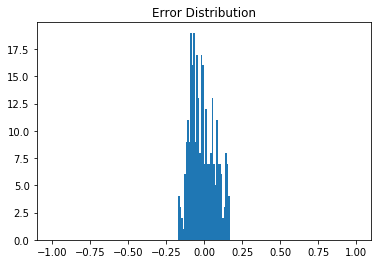

In [196]:
TEST = 300
correct = 0
tol = 0.1
errors = []
for i in range(TEST):
    print(f"TESTING {i + 1}/{TEST}", end = "\r")
    amt, inp = accelerating_distance_gen(ci)

    #run this to get FCN output
    out = model(inp).detach().numpy()
    
    #run this to use analytical output
    #out = approximate_amount(inp)

    if (abs(out - amt) < tol):
        correct += 1
    errors.append(out - amt)
print(f"WITHIN {tol} {correct}/{TEST} times")
print(f"AVERAGE ERROR {np.mean(np.abs(errors))}")

plt.title("Error Distribution")
plt.hist(errors, bins = 200, range = (-1, 1))
plt.show()